# Question1


Positive:
395    1982
443    1986
503    1991
575    1997
719    2009
791    2015
Name: YR, dtype: int64
Negative:
419    1984
467    1988
587    1998
599    1999
695    2007
731    2010
Name: YR, dtype: int64


/tmp/ipykernel_1747/3675529016.py:63: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statres, pval = ttest_1samp(da_elnino, 0)
/tmp/ipykernel_1747/3675529016.py:71: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statres, pval = ttest_1samp(da_lanina, 0)


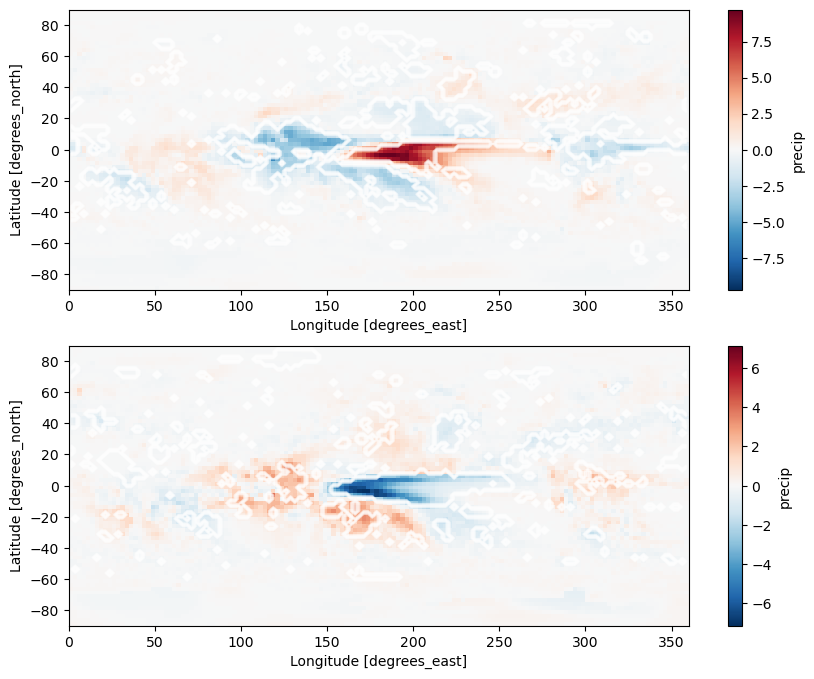

In [1]:
# -*- coding: utf-8 -*-
# ENSO composite analysis: CMAP Precip
import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap 
import numpy as np
import pandas as pd # http://pandas.pydata.org/
from netCDF4 import Dataset, num2date
from scipy.stats import ttest_1samp, pearsonr
import xarray as xr

lon1=0;lon2=360
lat1=-75;lat2=75
iyr1=1979
iyr2=2019

#read nino3.4 data from a CSV (comma-separated) file into DataFrame
nino34=pd.read_csv("/data/zhuowang/a/zhuowang/ATMS521/Data/detrend.nino34.ascii.txt", sep="\s+")
yr=nino34.YR
mon=nino34.MON
anom=nino34.TOTAL

#find indices of Dec in 1979-2020
D0=np.where((mon == 12) & (yr >= iyr1) & (yr <= iyr2))[0] # dec(0)
nyr=len(D0) 

#calculate DJF mean
DJF0=np.zeros(nyr)
for i in range(nyr):
    DJF0[i]=np.mean(anom[D0[i]:D0[i]+3])    

#stanrard deviation and selection
std=np.std(DJF0)
xm=np.mean(DJF0)
#Normalize the time series and save in a new array "DJF"
DJF=np.zeros(nyr)
DJF=(DJF0-xm)/std

pos=np.where(DJF >=  1.0)[0]
neg=np.where(DJF <= -1.0)[0]

#pos and neg DJF that pass test
yr_pos=yr[D0[pos]]
print("Positive:")
print(yr_pos)
yr_neg=yr[D0[neg]]
print("Negative:")
print(yr_neg)

#You can use "print ncFid.variables" to check the variables
fn1 = '/data/zhuowang/c/zhuowang/Data/CMAP/precip.mon.mean.nc'
ds1 = xr.open_dataset(fn1)
mean_of_seasons = ds1['precip'].resample(time='QS-DEC').mean(dim="time")
DJF_remove_mean = mean_of_seasons.groupby('time.season')['DJF']-mean_of_seasons.groupby('time.season')['DJF'].mean('time')

# • Perform the one-sample, two-sided t-test 
# • Plot the anomalies and highlight the anomalies exceeding the 95% confidence level at 
# each grid point. 
fig, axs = plt.subplots(2,figsize=[10,8])
da_elnino_only = DJF_remove_mean.sel(time=DJF_remove_mean.time.dt.year.isin([yr_pos])).mean('time')
da_elnino_only.plot(ax = axs[0])

da_elnino = DJF_remove_mean.sel(time=DJF_remove_mean.time.dt.year.isin([yr_pos]))
statres, pval = ttest_1samp(da_elnino, 0)
spy1 = np.where(pval < 0.05, 1, 0)
sig_elnino = xr.DataArray(data=spy1, dims=["lat", "lon"], coords=[da_elnino_only.lat,da_elnino_only.lon])
sig_elnino.plot.contour(ax = axs[0],colors = 'white', alpha = 0.5)

da_lanina_only = DJF_remove_mean.sel(time=DJF_remove_mean.time.dt.year.isin([yr_neg])).mean('time')
da_lanina_only.plot(ax = axs[1])
da_lanina = DJF_remove_mean.sel(time=DJF_remove_mean.time.dt.year.isin([yr_neg]))
statres, pval = ttest_1samp(da_lanina, 0)
spy1 = np.where(pval < 0.05, 1, 0)
sig_lanina = xr.DataArray(data=spy1, dims=["lat", "lon"], coords=[da_lanina_only.lat,da_lanina_only.lon])
sig_lanina.plot.contour(ax = axs[1],colors = 'white', alpha = 0.5)


# Question2


In [2]:
import xskillscore as xs

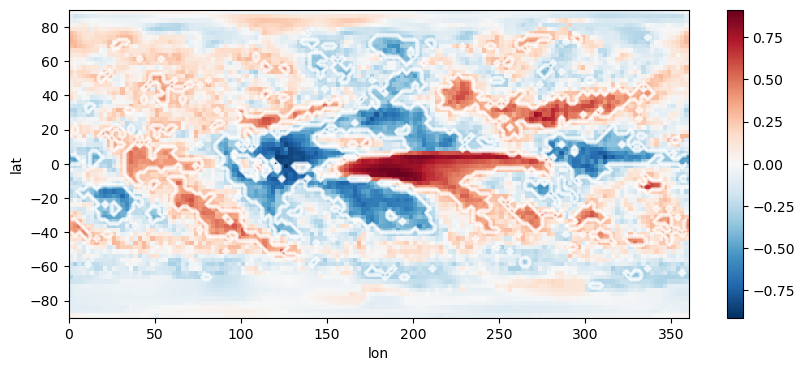

In [3]:
DJF_remove_mean = DJF_remove_mean.sel(time=slice('1979', '2019'))
DJF_array= DJF0
DJF_array = np.tile(DJF_array, (72, 144, 1))
DJF_array= xr.DataArray(DJF_array, coords=[ DJF_remove_mean.lat,DJF_remove_mean.lon,DJF_remove_mean.time], dims=[ 'lat','lon','time'])
cor0 = xr.corr(DJF_remove_mean, DJF_array, dim="time")
pvalue = xs.pearson_r_p_value(DJF_remove_mean, DJF_array, dim="time")
sig = pvalue.where(pvalue < 0.05, 1, 0)
fig, ax = plt.subplots(1,figsize=[10,4])
cor0.plot(ax = ax)
sig.plot.contour(ax = ax,colors = 'white', alpha = 0.5)


1) Do you need to remove the long-term mean before calculating the Pearson correlation? 
We don't need to remove the long-term mean. Because the pearson correlation calculate the linear relationship the long-term mean only impact the intercept.
2) Both the composite analysis in Problem #1 and the correlation analysis in this problem 
illustrate the impacts of the ENSO on precipitation. What differences do the two analysis 
methods have? 
the correlation method consider the whole time precipitation situation while the composite method only focus on the precipitation at the time with ENSO

# Question3

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from scipy import signal
from sklearn.linear_model import LinearRegression
from leave_one_out_MLR import lv1out_mlr
from normalization import normalize

In [5]:
#read and clean the data
nino34=pd.read_csv("/data/zhuowang/a/zhuowang/ATMS521/Data/Nino34_monthly-1979-2018.txt", sep="\s+")
amo=pd.read_csv("/data/zhuowang/a/zhuowang/ATMS521/Data/AMO_monthly-1979-2018.txt", sep="\s+")
nao=pd.read_csv("/data/zhuowang/a/zhuowang/ATMS521/Data/NAO_monthly-1979-2018.txt", sep="\s+")
rsst=pd.read_csv("/data/zhuowang/a/zhuowang/ATMS521/Data/RSST-1979-2018AMJ.txt", sep="\s+")
ace=pd.read_csv("/data/zhuowang/a/zhuowang/ATMS521/Data/ace_index.1979-2018.txt", sep="\s+")

amo = amo.set_index("Year")[["Apr","May","Jun"]].mean(axis=1).to_frame()
amo.columns =['amo']
nao = nao[["Apr","May","Jun"]].mean(axis=1).to_frame()
nao.columns =['nao']
nino34 = nino34.set_index("Year")[["Apr","May","Jun"]].mean(axis=1).to_frame()
nino34.columns =['nino34']

data_df= pd.concat([ace.set_index("Year")[["NATL"]],rsst.set_index("Year")[["MDR"]],nino34,amo, nao],axis = 1)
data_df.head()

,NATL,MDR,nino34,amo,nao
1979,94.0,25.8815,27.650000,-0.133667,1.326667
1980,137.8,26.1618,27.900000,0.078000,-1.126667
1981,88.2,25.9367,27.306667,-0.076333,0.073333
1982,26.8,25.6401,28.226667,-0.182333,-0.470000
1983,17.4,26.0191,28.626667,-0.010333,-0.260000


In [6]:
# select x1
data_df.corr()
print("So we select amo as the first variables")

So we select amo as the first variables


In [7]:
# • Construct a simple linear regression model for the ACE using x1 and calculate the ACC 
# between the predicted and the observed ACE using the leave-one-out method. 
"""
This is a user-defined function for leave-one-out MLR prediction
y0: predictor, a one-dimension time series of the length N
x0: predictors of the shape (N, M), where M is the number of predictors
"""


def lv1out_mlr(x0,y0):
    reg=LinearRegression()
    ys=np.zeros(len(y0))
    for i in range(len(y0)):
        x1=x0[i,:]          #testing data point
        x=np.delete(x0,i,axis=0) #construct the training dataset
        y=np.delete(y0,i,axis=0)
        reg.fit(x,y)        #train the model with x and y
        #reg.predict expects 2D array. array.reshape(1,-1) is used to reshape x1
        y1=reg.predict(x1.reshape(1, -1))  #predict y for the testing point
        ys[i]=y1[:]         #ys is the predicted time series of the predictand
    
    #calculate acc
    c = np.mean(y0)
    acc = np.mean((y0-c)*(ys-c)) / np.sqrt(np.mean((y0-c)**2)*np.mean((ys-c)**2))
    
    return acc, ys

acc_simple,_ = lv1out_mlr(data_df[['amo']].to_numpy(),data_df['NATL'].to_numpy())
print("acc for the simple linear regression is "+str(acc_simple))

acc for the simple linear regression is 0.6058711683378762


In [8]:
# • Select additional predictors using the forward selection method and stop adding more 
# predictors when the increase of ACC is less than 0.03. 
remain_variables_list = ["MDR","nino34","nao"]
variables_list = ["amo"]
acc_initial = acc_simple
acc_new = acc_simple
acc_diff = acc_simple
while(acc_diff>0.03):
    if len(remain_variables_list)==0:
        break
    for variable in remain_variables_list:
        acc_tmp, _ = lv1out_mlr(data_df[[*variables_list,variable]].to_numpy(),data_df['NATL'].to_numpy()) 
        if  acc_tmp> acc_new:
            acc_new = acc_tmp
            variable_next = variable
    variables_list.append(variable_next)
    acc_diff = acc_new-acc_initial
    acc_initial = acc_new
    remain_variables_list.remove(variable_next)
print("variables selected are "+str(variables_list) )

variables selected are ['amo', 'nino34']


Test:  0.6340335186002166 1.1207155946169143e-05


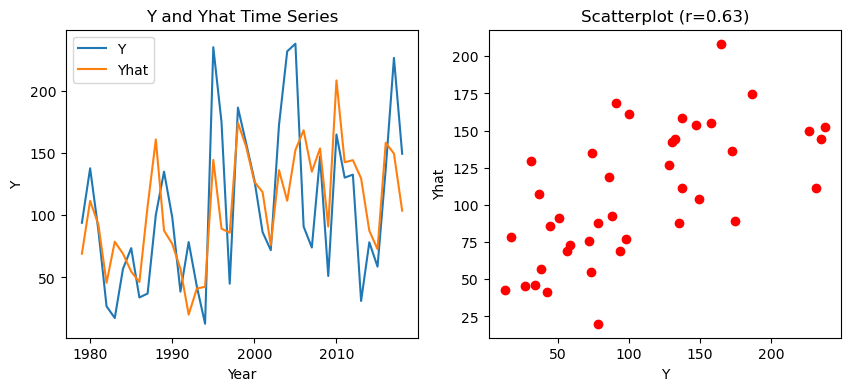

In [9]:


#testing random data
X=data_df[['amo', 'nino34']].to_numpy()
Y=data_df['NATL'].to_numpy()
yrs = data_df.index
_, yhat=lv1out_mlr(X,Y)
corr,p = stats.pearsonr(Y,yhat)
print('Test: ',corr,p)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(yrs,Y)
plt.plot(yrs,yhat)
plt.legend(['Y', 'Yhat'])
plt.xlabel('Year')
plt.ylabel('Y')
plt.title('Y and Yhat Time Series')

plt.subplot(1,2,2)
plt.plot(Y,yhat,'ro')
plt.xlabel('Y')
plt.ylabel('Yhat')
r,p=stats.pearsonr(Y,yhat)
plt.title('Scatterplot (r='+str(round(r,2))+')')
fmt='png'
plt.savefig('fig-MLR-sample.'+fmt,format=fmt,bbox_inches='tight')

plt.show(block=False)
